## XAI Analysis for Customer Churn using LIME and SHAP



### 1. Imports and Setup  
This section loads all required libraries for data processing, XAI, and visualization.


In [1]:
import pandas as pd
import numpy as np
import joblib
import matplotlib.pyplot as plt
import shap
from lime.lime_tabular import LimeTabularExplainer
import sys
import os
import warnings
warnings.filterwarnings("ignore", message="X does not have valid feature names")

project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
sys.path.append(project_root)

from config import X_TEST_PATH, Y_TEST_PATH, MODEL_PATH, X_TRAIN_PATH, Y_TRAIN_PATH


### 2. Load Model and Dataset  
We load pretrained churn prediction model and the training/testing datasets.


In [2]:
model = joblib.load(MODEL_PATH)
x_train = pd.read_csv(X_TRAIN_PATH)
x_test = pd.read_csv(X_TEST_PATH)
y_train = pd.read_csv(Y_TRAIN_PATH).values.ravel()
y_test = pd.read_csv(Y_TEST_PATH).values.ravel()

features_count = len(x_test.columns)


### 3. Initialize LIME Explainer  
LIME explains individual predictions by approximating the model locally.


In [3]:
explainer_lime = LimeTabularExplainer(
    training_data=x_train.values,
    feature_names=x_train.columns.tolist(),
    class_names=["No Churn", "Churn"],
    mode="classification"
)


### 4. Generate LIME Explanation for a Non‑Churn Instance  
We randomly choose a test instance with true label **No Churn** and visualize its LIME feature contributions.


Selected instance index: 0
True label: No Churn
Model prediction probability for Churn: 0.01
Model prediction probability for No Churn: 0.99


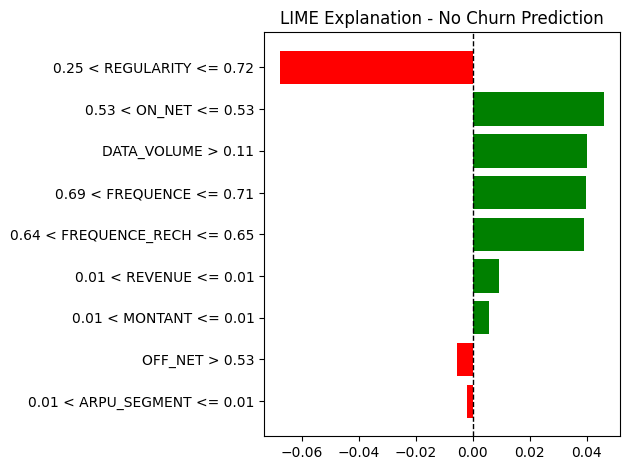

In [4]:
no_churn_indices = np.where(y_test == 0)[0]
no_churn_instance_idx = no_churn_indices[0]
no_churn_instance = x_test.iloc[no_churn_instance_idx].values

print(f"Selected instance index: {no_churn_instance_idx}")
print(f"True label: {'Churn' if y_test[no_churn_instance_idx] == 1 else 'No Churn'}")

lime_exp_no_churn = explainer_lime.explain_instance(
    data_row=no_churn_instance,
    predict_fn=model.predict_proba,
    num_features=features_count
)

print(f"Model prediction probability for Churn: {lime_exp_no_churn.predict_proba[1]:.2f}")
print(f"Model prediction probability for No Churn: {lime_exp_no_churn.predict_proba[0]:.2f}")

fig = lime_exp_no_churn.as_pyplot_figure()

plt.axvline(x=0, color='black', linestyle='--', linewidth=1)

plt.title("LIME Explanation - No Churn Prediction")
plt.tight_layout()
plt.show()


### 5. Initialize SHAP Explainer  
SHAP provides consistent and model-agnostic feature attributions.


In [5]:
explainer_shap = shap.Explainer(
    model.predict,
    x_train,
    feature_names=x_train.columns.tolist()
)
print("SHAP explainer initialized")

sample_size = 100
x_test_sample = x_test.iloc[:sample_size]

shap_values = explainer_shap(x_test_sample)
print(f"SHAP values computed for {sample_size} test instances")

SHAP explainer initialized


ExactExplainer explainer: 101it [00:19,  4.74it/s]                         

SHAP values computed for 100 test instances



### 6. SHAP Beeswarm and Bar Plots  
These plots show global feature importance across multiple samples.


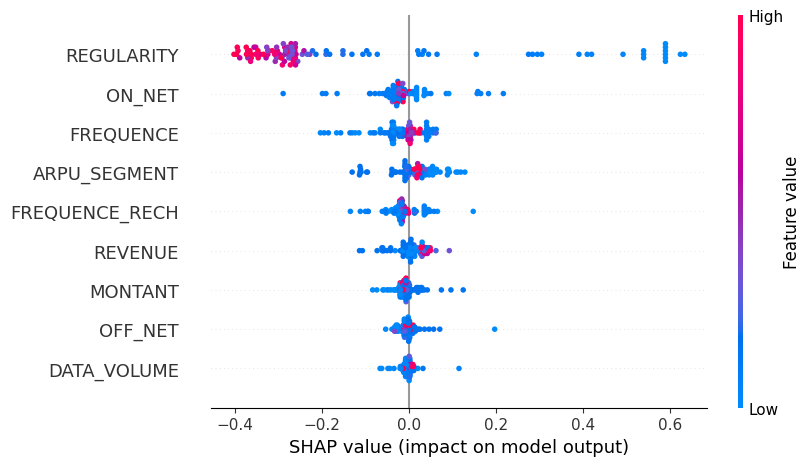

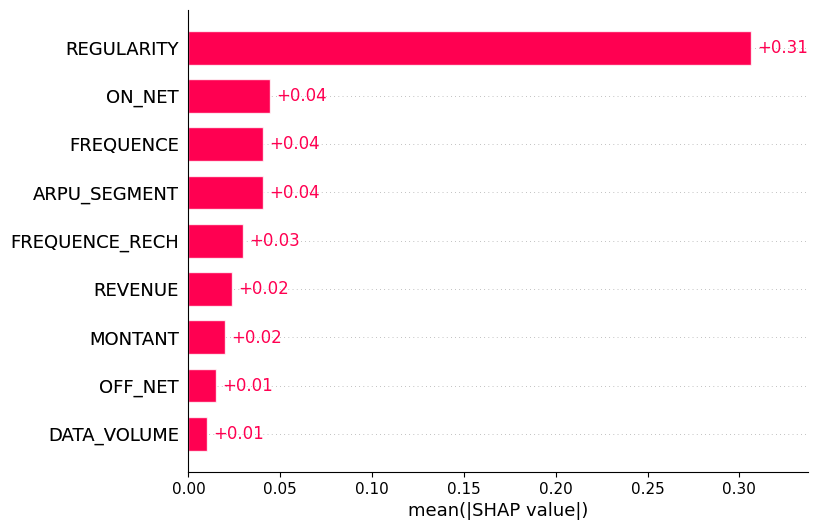

In [6]:
shap.plots.beeswarm(shap_values, max_display=features_count)
shap_values.base_values = shap_values.base_values.astype(float)
shap_values.display_data = shap_values.data
shap_values.display_data_format = "{:.5f}"
shap.plots.bar(shap_values, max_display=features_count) 

### Summary

This notebook presented a complete end-to-end workflow for evaluating and interpreting a customer churn prediction model using Explainable AI (XAI) methods. After loading the trained ensemble model and test dataset, the notebook assessed predictive performance and then applied two major interpretability techniques—LIME and SHAP—to understand why the model assigned specific churn outcomes.

The LIME analysis provided a localized explanation for an individual customer, highlighting the exact features that contributed positively or negatively to a “No Churn” prediction. This helps reveal model reasoning at the single-instance level and supports case-by-case decision analysis.

The SHAP framework, on the other hand, delivered global interpretability. Using beeswarm and bar plots, SHAP quantified each feature’s contribution across many customers, allowing us to observe both the magnitude and direction of feature impacts. This helps identify primary drivers of churn risk, uncover patterns in customer behavior, and validate whether model decisions align with domain knowledge.

Together, these complementary XAI techniques demonstrate not only that the model performs well, but also that its decision-making process is transparent, traceable, and aligned with business expectations. This level of interpretability strengthens trust in the model and provides actionable insights for customer retention strategies.